# Lesson 1

This is the first of three lessons that introduce the tools and processes of machine learning.
As an exercise, we will participate in a data science competition hosted by DrivenData, called [Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines](https://www.drivendata.org/competitions/66/flu-shot-learning/).

The goal of this competition is to use survey data to predict which people chose to get vaccinated against H1N1,
which is the influenza virus that caused the [2009 swine flu pandemic](https://en.wikipedia.org/wiki/2009_swine_flu_pandemic).

It might might not be obvious why it is useful to predict whether someone gets vaccinated, especially when we already know the answers, as we do in this example.
But during the COVID-19 pandemic we learned several important lessons: (1) our ability to respond to a public health crisis depends strongly on individuals' willingness to get vaccinated, and (2) that willingness depends on many factors in complex ways.
Machine learning provides tools for identifying those factors, understanding complex relationships, and generating predictions -- all of which can help guide decisions about public health communication and intervention.

The dataset we will use is from the [National 2009 H1N1 Flu Survey](https://www.cdc.gov/nchs/nis/data_files_h1n1.htm), which ran from October 2009 through June 2010.
This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in addition to questions about their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards reducing disease transmission.

As we explore the data, we will get a better sense of the information it contains and how it can be useful.
The primary tools we will use are:

* Pandas for reading and exploring data, and

* Scikit-learn for processing data, making models, and generating predictions.

In the first lesson, we will use a relatively simple algorithm to generate predictions, submit the predictions to the competition site, and get a score.
In future lessons we'll explore additional algorithms and take advantage of tools that make it easier to develop models and test predictions. 

## Lesson 1

Before we get started, you should sign up for the competition.
Go to [the DrivenData site](https://www.drivendata.org/) and log in or create an account.
Then go to [the competition page](https://www.drivendata.org/competitions/66/flu-shot-learning/) and read the overview.
Select the button that says "Join the Competition"; then you can read [the problem description](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/).

The goal of the competition is to predict two **labels**: 

* `h1n1_vaccine`, which indicates whether each respondent received the H1N1 vaccine, and 

* `seasonal_vaccine`, which indicates whether they got the usual annual flu shot.

The problem description lists the **features** in the dataset, which are columns of data we'll use to make predictions.

In the first lesson we will use only the features that are represented with numbers; in the second lesson we'll see how to add features represented as strings.

With that overview of the problem, let's get started. 

## Download the data

If you have joined the competition, you have access to the [data download page](https://www.drivendata.org/competitions/66/flu-shot-learning/data/).
There are four files there: the training features and training labels we will use to make a model, the test data we will use to make predictions, and a submission file that demonstrates the format we'll use to submit predictions to the competition site.

You can download these files by following the links on the data download page, or run the code below to download them automatically.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists("utils.py"):
    !wget https://raw.githubusercontent.com/drivendataorg/tutorial-flu-shot-learning/main/utils.py

In [3]:
from utils import download_data_files

download_data_files()

In [4]:
# this won't be necessary in later versions
from sklearn import set_config
set_config(display="diagram")

## Read the labels

Let's start by reading `training_set_labels.csv`, which contains the known labels for the subset of the survey respondents whose data we'll use to train the model.
We'll use Pandas to read the file and put the results in a `DataFrame`.

In [6]:
labels_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
labels_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


The file contains one row for each respondent and one column for each of the labels. These labels are the **target variables**, that is, the values we are trying to predict. 

The index of the `DataFrame` contains numerical IDs for the respondents.

In [7]:
labels_df.shape

(26707, 2)

We can use `value_counts` to compute the fraction of respondents who got the H1N1 vaccine.

In [8]:
labels_df["h1n1_vaccine"].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

And the fraction who got the seasonal flu vaccine.

In [9]:
labels_df["seasonal_vaccine"].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

About 21% of the respondents got the H1N1 vaccine, and almost 47% got the flu shot.

**Exercise:** What do we get if we run `value_counts` on the whole `DataFrame`, rather than one column at a time? How do we interpret the results?

In [10]:
# Solution

# It's a cross tabulation (which is clearer if we unstack it)
# For example, only 3% got the H1N1 vaccine and *not* the seasonal flu vaccine

labels_df.value_counts(normalize=True).unstack()

seasonal_vaccine,0,1
h1n1_vaccine,,
0,0.497810,0.289737
1,0.036582,0.175871


## Read the features

Now that we know the values of the target variables, let's look at the features. Again, we'll use Pandas to read the file and store the results in a `DataFrame`.

In [11]:
features_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
features_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


The `DataFrame` has one row for each respondent and one column for each of the 35 features.

In [12]:
features_df.shape

(26707, 35)

Again, the index contains IDs for the respondents, which we can use to confirm that the rows in `features_df` line represent the same respondents as the rows in `labels_df`.

In [13]:
(features_df.index == labels_df.index).all()

True

The `dtypes` attribute indicates the data type of each feature.

In [14]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

Most are `float64`, which means they are floating-point numbers. Some are `object`, which means they could contain any kind of Python object -- but as we will see, they are mostly strings.

Some of the `float64` columns represent actual numbers, like the number of children in the respondent's household.

In [15]:
features_df["household_children"].value_counts().sort_index()

0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: household_children, dtype: int64

Some are ordinal categorial features represented by integers, like the level of H1N1 concern.

In [16]:
features_df["h1n1_concern"].value_counts().sort_index()

0.0     3296
1.0     8153
2.0    10575
3.0     4591
Name: h1n1_concern, dtype: int64

Some are unordered categorical features represented by integers, like sex.

In [17]:
features_df["sex"].value_counts().sort_index()

Female    15858
Male      10849
Name: sex, dtype: int64

Note that in results from `value_counts`, the `dtype` refers to the counts, which are integers, not the values in the feature.

**Exercise:** Compute the value counts of `age_group`. What kind of feature is this (numerical or categorical, ordered or not), and how is it represented?

In [18]:
# Solution

# It's a numerical quantity grouped into ordered categories, represented by strings.

features_df["age_group"].value_counts().sort_index()

18 - 34 Years    5215
35 - 44 Years    3848
45 - 54 Years    5238
55 - 64 Years    5563
65+ Years        6843
Name: age_group, dtype: int64

## Predictive value

Now let's take a quick look and see which features might help us predict vaccination decisions.
For example, one of the features in the dataset is `h1n1_concern`, which contains responses to the following question [from the survey](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NIS/nhfs/nhfspuf_QUEX.PDF):

> How concerned are you about the H1N1 flu? Would you say you are very concerned,
somewhat concerned, not very concerned, or not at all concerned?

The responses are represented with integers from 0 to 3, with the following encoding:

```
    0 = Not at all concerned; 
    1 = Not very concerned; 
    2 = Somewhat concerned; 
    3 = Very concerned.
```

A few people said they did not know, or refused to answer the question. These responses are represented by the special value `NaN`.

Using a cross tabulation, we can see what fraction of people are vaccinated at each level of `h1n1_concern`:

In [19]:
def crosstab(x, y):
    """Make a cross tabulation and normalize the columns as percentages.

    Args:
        x: sequence of values that go in the index
        y: sequence of values that go in the columns

    returns: DataFrame
    """
    return pd.crosstab(x, y, normalize="columns") * 100

In [20]:
crosstab(labels_df["h1n1_vaccine"], features_df["h1n1_concern"])

h1n1_concern,0.0,1.0,2.0,3.0
h1n1_vaccine,,,,
0,86.438107,82.865203,76.614657,70.790677
1,13.561893,17.134797,23.385343,29.209323


Among people who are "not at all concerned" (value 0), only about 13% chose to get vaccinated. Among people who are "very concerned" (value 3), about 29% did. So it seems like this feature has "predictive value"; that is, if we know `h1n1_concern`, we can make a better prediction about vaccination status (as you might have expected).

Now let's do the same thing with `household_children`:

In [21]:
crosstab(labels_df["h1n1_vaccine"], features_df["household_children"])

household_children,0.0,1.0,2.0,3.0
h1n1_vaccine,,,,
0,78.668595,78.771654,78.037709,80.022896
1,21.331405,21.228346,21.962291,19.977104


The fraction of people who got vaccinated is close to 21%, regardless of the number of children in the household.
It looks like people with 3 children might be slightly less likely to get vaccinated (maybe they don't have time), but the number of people in this group is relatively small, so this difference might not mean anything.

In [22]:
features_df["household_children"].value_counts()

0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: household_children, dtype: int64

Either way, it looks like this feature doesn't have much predictive value.

**Exercise:** Explore one or two more features and see if you can find others that seem to have predictive value.

In [23]:
# Solution

crosstab(labels_df["h1n1_vaccine"], features_df["doctor_recc_h1n1"])

doctor_recc_h1n1,0.0,1.0
h1n1_vaccine,,
0,86.362924,46.764053
1,13.637076,53.235947


In [24]:
# Solution

crosstab(labels_df["h1n1_vaccine"], features_df["health_insurance"])

health_insurance,0.0,1.0
h1n1_vaccine,,
0,85.253456,68.228715
1,14.746544,31.771285


## Fill missing values

We could continue to explore one feature at a time, but our goal is to make a model that identifies the most predictive features and uses them to generate predictions.
The model we will start with is logistic regression, which is a relatively simple algorithm (compared to others we'll see soon).

Before we can use it, there are two issues we have to deal with:

1. The implementation of logistic regression in Scikit-learn does not work if the dataset contains `NaN` values, so we will have to do something about missing data, and

2. Numerical and categorical data are handled differently, so we have to split them up and prepare them separately.

In this lesson we'll start with just the numerical features, including numerically-encoded ordinal features. In the next lesson we'll add the categorical features.

We can use `select_dtypes` to pull out the features that contain numbers.

In [25]:
numeric_features_df = features_df.select_dtypes(include=np.number)
numeric_features_df.shape

(26707, 23)

For most features, we are missing some values. For a few of them, we are missing a lot!

In [26]:
numeric_features_df.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
household_adults                 249
household_children               249
dtype: int64

To deal with missing data, one option is **imputation**, which means we fill in missing data with values we think are plausible.
Scikit-learn provides an object called `SimpleImputer` that does this kind of missing value imputation.
One of the strategies it provides is `mean`, which replaces missing values with the mean of the non-missing values.

To use it, we have to make a `SimpleImputer` object and then fit it to the data.
In this example, "fitting the data" involves computing the mean of every feature.

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(numeric_features_df)

SimpleImputer()

Now that the `SimpleImputer` knows the means, we can use it to transform the data.

In [28]:
filled = imputer.transform(numeric_features_df)
filled

array([[1., 0., 0., ..., 2., 0., 0.],
       [3., 2., 0., ..., 4., 0., 0.],
       [1., 1., 0., ..., 2., 2., 0.],
       ...,
       [2., 2., 0., ..., 2., 0., 0.],
       [1., 1., 0., ..., 2., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

The result is an array that contains the data from `numeric_features_df` except that the `NaN` values have been replaced with numbers.

To show the changes, I'll put the array into a `DataFrame` with the index and columns from `numeric_features_df`.

In [29]:
filled_df = pd.DataFrame(
    filled, index=numeric_features_df.index, columns=numeric_features_df.columns
)

We can confirm that there are no missing values in the filled data.

In [30]:
filled_df.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
dtype: int64

To see the values that got filled in, let's look at `health_insurance`.
The mean of the non-missing values is about 0.88.

In [31]:
features_df["health_insurance"].mean()

0.8797200859142243

If we look at this column in `filled_df`, we see that it contains `0` or `1` for the cases with known data, and `0.88` where there was missing data.

In [32]:
filled_df["health_insurance"]

respondent_id
0        1.00000
1        1.00000
2        0.87972
3        0.87972
4        0.87972
          ...   
26702    0.87972
26703    1.00000
26704    0.87972
26705    0.00000
26706    1.00000
Name: health_insurance, Length: 26707, dtype: float64

One way to interpret these imputed values is that they represent probabilities. If we don't know whether a particular respondent has life insurance, we might say there is an 88% probability they do, based on the proportion of other respondents who do. 

**Exercise:** What is the imputed value of `h1n1_concern`, and how would you interpret it?

In [33]:
filled_df["h1n1_concern"].value_counts()

2.000000    10575
1.000000     8153
3.000000     4591
0.000000     3296
1.618486       92
Name: h1n1_concern, dtype: int64

## Making a model

Now we're ready to fit a model to the data. Scikit-learn provides a `LogisticRegression` object we can instantiate like this:

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model

LogisticRegression()

To fit the model to the data, we have to provide the actual labels, which we can get from `labels_df`.

In [35]:
y_true = labels_df["h1n1_vaccine"]
y_true.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

`y_true` contains the labels from the training data, which we know are correct.
Now we can fit the model like this.

In [36]:
model.fit(filled, y_true)

LogisticRegression()

The return value from `fit` is the same `LogisticRegression` object, but now it contains the **coefficients** it computed to fit the data. Here's what they look like.

In [37]:
model.coef_

array([[-0.09829494,  0.15465565,  0.14442064, -0.04637177,  0.18576658,
         0.00280365, -0.18776983, -0.01832096,  0.04275457,  1.9942695 ,
        -0.50661379,  0.12827365,  0.23467494,  0.73258467,  1.31045617,
         0.61534921,  0.35163616, -0.01296847,  0.10357477,  0.15628207,
        -0.08167706,  0.01464795, -0.09577733]])

This array contains one coefficient for each feature, which we can see more clearly if we put them into a `Series` with the names of the features.

In [38]:
pd.Series(model.coef_.flatten(), numeric_features_df.columns)

h1n1_concern                  -0.098295
h1n1_knowledge                 0.154656
behavioral_antiviral_meds      0.144421
behavioral_avoidance          -0.046372
behavioral_face_mask           0.185767
behavioral_wash_hands          0.002804
behavioral_large_gatherings   -0.187770
behavioral_outside_home       -0.018321
behavioral_touch_face          0.042755
doctor_recc_h1n1               1.994270
doctor_recc_seasonal          -0.506614
chronic_med_condition          0.128274
child_under_6_months           0.234675
health_worker                  0.732585
health_insurance               1.310456
opinion_h1n1_vacc_effective    0.615349
opinion_h1n1_risk              0.351636
opinion_h1n1_sick_from_vacc   -0.012968
opinion_seas_vacc_effective    0.103575
opinion_seas_risk              0.156282
opinion_seas_sick_from_vacc   -0.081677
household_adults               0.014648
household_children            -0.095777
dtype: float64

These coefficients represent weights assigned to each feature.
By themselves, they are not easy to interpret, for several reasons:

1. They are in terms of log odds ratios, so it takes some math to express them in terms people understand,

2. The magnitudes of the coefficients depend on the scale of the features. Since the features are on different scales, we can't meaningfully compare them to each other.

3. They are the result of multiple regression, so each one represents the effect of one factor while controlling for the others. Because of these interactions, the signs and magnitudes are often not what we expect.

4. Some of them probably represent meaningful relationships between the features and the labels, but some of them are the result of randomness.

Rather than try to interpret them, an alternative is to treat the model as a "black box", which is to say that we will use it to generate predictions without giving much thought to how it works.

## Generating predictions

To generate predictions, we can use the `predict` method like this.

In [39]:
pred = model.predict(filled)
pred

array([0, 0, 0, ..., 0, 0, 0])

For this demonstration, I am generating predictions for the same set of features we used to train the model. This is usually not a good idea, for reasons we'll see soon. But for now it gives us a quick way to see what the predictions look like.

I'll use the following function to count how many times each prediction is generated.

In [40]:
def value_counts(seq, **options):
    """Version of value_counts that works with any sequence type.

    Args:
        seq: sequence
        options: passed to pd.Series.value_counts

    Returns: pd.Series
    """
    return pd.Series(seq).value_counts(**options)

In [41]:
value_counts(pred)

0    23272
1     3435
dtype: int64

In [42]:
value_counts(pred, normalize=True) * 100

0    87.138203
1    12.861797
dtype: float64

For 87% of the respondents, the model predicts they did not get the H1N1 vaccine; for the other 13%, it predicts that they did.
To see how good these predictions are, we can see how often the prediction is the same as the actual value.

In [43]:
accuracy = (pred == y_true).mean()
accuracy

0.8349121953046018

On the face of it, the accuracy of the model is 83%. That might sound good, but it is misleading for two reasons:

1. We used the same data to train the model and test it; as a result, the accuracy we just computed is higher than what we should expect on the test data.

2. Remember that only 21% of the respondents got the vaccine, which means that 79% did not. A model that always predicts "no" would be accurate 79% of the time.

The model we just created is more accurate than predicting "no" every time, but not by much.

In [44]:
y_true.mean()

0.2124536638334519

Part of the problem is that we are asking the model to make a **deterministic** prediction; that is, for each respondent, it predicts "yes" or "no". Predictions like this are hard to evaluate; as this example shows, accuracy alone is not particularly informative. Also, for many practical purposes, deterministic predictions are not particularly useful.
An alternative is **probablistic** prediction, which computes for each respondent a *probability* of being vaccinated, rather than a yes/no prediction.

`model` provides a function called `predict_proba` that generates probabilistic predictions.

In [45]:
pred_array = model.predict_proba(filled)
pred_array

array([[0.97088866, 0.02911134],
       [0.72674757, 0.27325243],
       [0.94935077, 0.05064923],
       ...,
       [0.73713129, 0.26286871],
       [0.9904698 , 0.0095302 ],
       [0.86162803, 0.13837197]])

The result is an array that contains one row for each respondent and one column for each **class**.
The classes are the possible values of `h1n1_vaccine`:

In [46]:
model.classes_

array([0, 1])

To see how the results correspond to the respondents and classes, we can put the array into a `DataFrame`.

In [47]:
pd.DataFrame(pred_array, index=features_df.index, columns=model.classes_)

,0,1
respondent_id,,
0,0.970889,0.029111
1,0.726748,0.273252
2,0.949351,0.050649
3,0.932046,0.067954
4,0.959427,0.040573
...,...,...
26702,0.966823,0.033177
26703,0.418605,0.581395
26704,0.737131,0.262869


According to the model, the respondent with ID `0` has a 97% chance of being in class `0`, which is unvaccinated, and the remaining 3% chance of being in class `1`, which is vaccinated.

Since the two columns always add up to 1, we don't really need both of them. We can select the second column, which is the probability of being vaccinated, like this: 

In [48]:
y_pred = pred_array.T[1]
y_pred

array([0.02911134, 0.27325243, 0.05064923, ..., 0.26286871, 0.0095302 ,
       0.13837197])

The average of the probabilities is 0.21, which is close to the actual fraction of the respondents who were vaccinated. 

In [49]:
y_pred.mean()

0.2124531946415117

The following figure shows the distribution of the predicted probabilities.

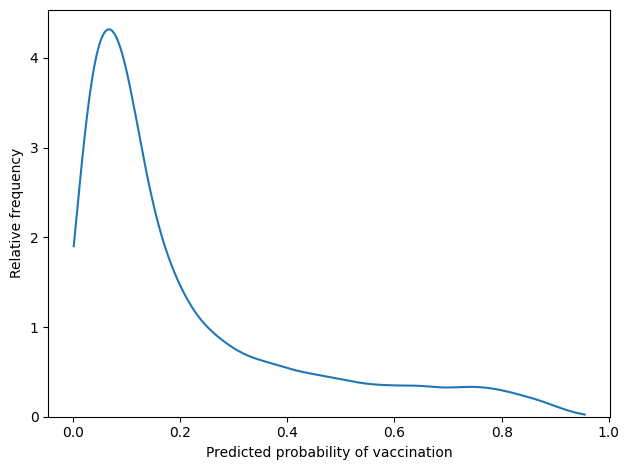

In [50]:
import seaborn as sns
from utils import decorate

sns.kdeplot(y_pred, cut=0)

decorate(xlabel="Predicted probability of vaccination", ylabel="Relative frequency")

For most respondents, the predicted probability is less than 20%. There are only a few respondents whose predicted probabilities exceed 50%.

## Evaluating the predictions

There are several ways to evaluate the quality of these predictions.
For the competition, the metric that determines the order of the leaderboard is the Area Under the Receiver Operator Characteristic curve (AUROC), sometimes just called the Area Under the Curve (AUC).

This metric takes some explaining; rather than going deep on it now, here's what you need to know:

1. The AUROC score quantifies the quality of probablistic predictions on a scale from 0.5 to 1.

2. Higher scores indicate more accurate predictions. At the extremes, 1 indicates perfect predictions and 0.5 indicates predictions that are no better than chance.

Scikit-learn provides a function that takes the predictions and the true labels and computes the AUC score:

In [51]:
from sklearn.metrics import roc_auc_score

score1 = roc_auc_score(y_true, y_pred)
score1

0.8301287538133717

In this example, the AUC score is near 0.83.

One way to interpret this number is as a **concordance probability**. Suppose we choose two cases at random and generate predictions for both. If the predicted probability is higher for one of the cases, the probability is 83% that we are right, and the actual probability is higher for that case.

That's better than 50%, which is how well we would do by chance.
But it is not great; we would be wrong about 17% of the time.

To summarize, I would say that this model is moderately successful.
But remember that we trained and tested with the same data.
To evaluate the model property, we need to use the test data.
We'll do that soon, but first we have to generate predictions for the other target variable, `seasonal_vaccine`.

## Using a pipeline

To generate the second set of predictions, we could copy the code from the previous section, but it will be easier and more reliable to define a **pipeline** that encapsulates the steps:

1. Select the numerical columns,

2. Impute missing values,

3. Fit a logistic regression model.

The first two are **transformers**, which means that they make modified version of the input data. The last is an **classifier**, which means that it uses the data to estimate the coefficients of the model.

To select the numerical columns, I'll get the column names from `numeric_features_df`:

In [52]:
numeric_cols = numeric_features_df.columns

Previously we used Pandas to select these columns, but an alternative is to use a `ColumnTransformer`:

In [53]:
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer([("numeric", "passthrough", numeric_cols)])
selector

ColumnTransformer(transformers=[('numeric', 'passthrough',
                                 Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])

The argument to `ColumnTransformer` is a list of tuples, although in this example, there is only one tuple in the list. The tuple contains three elements:

* `numeric` is a name we can choose arbitrarily; in this example, it indicates that this part of the pipeline deals with numeric data.

* `passthrough` indicates that the selected columns are passed along unchanged.

* `numeric_cols` is the sequence of column names that will be selected.

Now we're ready to make a `Pipeline`, which is an object that represents a sequence of transformers and classifiers.

In [54]:
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("selector", selector),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", LogisticRegression()),
    ]
)

The first stage of the pipeline is `selector`, which is the `ColumnTransformer` we just made.
The second stage is a `SimpleImputer`, which is a transformer that fills missing values.
The third stage is a `LogisticRegression`, which is as estimator.

Because this pipeline contains as estimator, we can think of it as a model.
Like a model, it provides a `fit` function.

In [55]:
model.fit(features_df, y_true)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chron...tion', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())])

When we invoke `fit` on the `Pipeline`, we provide the training data and the training labels.
The `Pipeline`

* Invokes `fit` on the `ColumnTransformer`, which doesn't actually do anything.

* Invokes `transform` on the `ColumnTransformer`, which selects the numeric columns.
 
* Invokes `fit` on the `SimpleImputer`, which computes the means of the features.

* Invokes `transform` on the `SimpleImputer`, which fills missing values with the means it just computed.

* Invokes `fit` on the `LogisticRegression`, which estimates the coefficients.

After fitting the pipeline, we can use it to generate predictions:

In [56]:
pred_pipeline = model.predict_proba(features_df)
pred_pipeline

array([[0.97088866, 0.02911134],
       [0.72674757, 0.27325243],
       [0.94935077, 0.05064923],
       ...,
       [0.73713129, 0.26286871],
       [0.9904698 , 0.0095302 ],
       [0.86162803, 0.13837197]])

Again, the result has one column for each class, but we only need the second column, which is the predicted probability that each respondent got the H1N1 vaccine.

In [57]:
y_pred_pipeline = pred_pipeline.T[1]

We can confirm that the results we get from the pipeline are the same as what we computed step by step.

In [58]:
np.allclose(y_pred, y_pred_pipeline)

True

And compute the AUC score again.

In [59]:
score1 = roc_auc_score(y_true, y_pred_pipeline)
score1

0.8301287538133717

To make a model for the seasonal vaccine, we'll make another pipeline, just like the first.

In [60]:
model2 = Pipeline(
    [
        ("selector", selector),
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("classifier", LogisticRegression()),
    ]
)

And train it with the `seasonal_vaccine` labels.

In [61]:
y_true2 = labels_df["seasonal_vaccine"]
model2.fit(features_df, y_true2)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chron...tion', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object'))])),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression())])

Now we can generate predictions.

In [62]:
y_pred2 = model2.predict_proba(features_df).T[1]
y_pred2

array([0.06058864, 0.25686739, 0.24161276, ..., 0.72989908, 0.01992929,
       0.25375547])

And compute an AUC score.

In [63]:
score2 = roc_auc_score(y_true2, y_pred2)
score2

0.8329128480430075

The AUC score is about the same as for the H1N1 vaccine.

## Predictions for the test features

So far we have used the same dataset to train the model and to generate predictions.
But the goal of the model is to generate predictions for new cases we have not seen before.
In the context of the competition, `test_set_features.csv` contains the cases we are supposed to generate predictions for. So let's read the test features:

In [64]:
test_features_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")
test_features_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


We'll use the first model to generate predictions for the H1N1 vaccine.

In [65]:
test_pred1 = model.predict_proba(test_features_df).T[1]
test_pred1

array([0.13489335, 0.02351709, 0.36902136, ..., 0.20900421, 0.04917523,
       0.63990223])

And the second model to generate predictions for the seasonal flu vaccine.

In [66]:
test_pred2 = model2.predict_proba(test_features_df).T[1]
test_pred2

array([0.43785044, 0.05749332, 0.61969265, ..., 0.40580782, 0.29943892,
       0.64489359])

This example demonstrates the benefits of using pipelines. First, they are convenient. Once we have trained a model, we can generate predictions with a single line of code. More importantly, they encapsulate every step of the process, including selection and imputation. As a result, they help prevent errors that would be more likely if we had to copy and paste the code.

To submit these predictions on the competition site, we have to write a CSV file in the right format. The provided file `submission_format.csv` shows what it should look like.

In [67]:
submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


When we loaded `training_set_features.csv`, you might remember that we checked that the respondents in the index are the same as the ones in `training_set_labels.csv`.
Similarly, let's check that the respondents in `submission_format.csv` are the same as the ones in `test_set_features.csv`.

In [68]:
(submission_df.index == test_features_df.index).all()

True

We can store the predictions in `submission_df` like this:

In [69]:
submission_df["h1n1_vaccine"] = test_pred1
submission_df["seasonal_vaccine"] = test_pred2

And use Pandas to write the predictions to a CSV file.

In [70]:
submission_df.to_csv("submission1.csv")

Here's what the format looks like.

In [71]:
!head submission1.csv

respondent_id,h1n1_vaccine,seasonal_vaccine
26707,0.13489334671523973,0.437850444269809
26708,0.023517088466908788,0.05749331641249102
26709,0.3690213624059212,0.6196926518118399
26710,0.4741970765807566,0.8014046599607151
26711,0.3171858690900654,0.6457667797571401
26712,0.43357037097949813,0.8956160847424255
26713,0.24605223330386922,0.29996146612306546
26714,0.12545052415532,0.2440902908757473
26715,0.02851156608782157,0.13501014787759547


In [72]:
if "google.colab" in sys.modules:
    from google.colab import files
    files.download("submission1.csv")

If we submit these predictions to the platform, we get a single score, which is the average of the AUC scores for the two target variables.

The score for these predictions is 0.8204, which is not quite as good as the score we got when we tested the model on the same data it was trained with. That's to be expected.
The difference indicates that the model is slightly **overfit**; that is, it has learned some details of the training data that are not applicable to the test data.

In this example, the difference is small.
Soon we will see examples where it is much bigger.

## Summary

In this lesson, we loaded the training labels and computed the proportion of respondents who got each vaccine.
Then we explored the training features, identifying some that seem to have predictive value.
And we used a `SimpleImputer` to fill missing data.

We built a logistic regression model, trained it with one of the target variables, generated predictions, and computed an AUC score.
The we repeated the process with a `Pipeline`, which helps to organize the stages of data transformation and model fitting.

Finally, we generated predictions for the respondents in the test data, submitted the predictions on the competition site and put an initial score on the leaderboard.

So far we have only used the numeric features; in the next lesson, we'll see if the categorical features have additional predictive value, and we'll try to move up the leaderboard!